# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

     SpeakerID Gender Phoneme        F1        F2        F3        F4  \
115       elc0      F      ae  0.626849  2.040568  2.737875  4.225691   
286       elc0      F      ae  0.635120  2.129651  3.035465  4.324663   
296       elc0      F      ae  0.765164  1.928721  2.329302  4.138947   
378       dab0      M      ae  0.657672  1.512031  2.473496  3.353928   
530       dab0      M      ae  0.639403  2.078772  2.610199  3.651029   
...        ...    ...     ...       ...       ...       ...       ...   
6719      jln0      M      ae  0.871840  1.468683  2.460316  3.376118   
6860      pam0      M      ae  0.652087  1.519256  2.211460  3.977117   
6978      pam0      M      ae  0.673218  1.611651  2.372237  3.898877   
7108      pam0      M      ae  0.708950  1.390807  2.111469  4.040951   
7113      pam0      M      ae  0.651769  1.622842  2.485576  4.106205   

            B1        B2        B3        B4  
115   0.163549  0.312099  0.381565  0.419437  
286   0.191081  0.352319  0.3

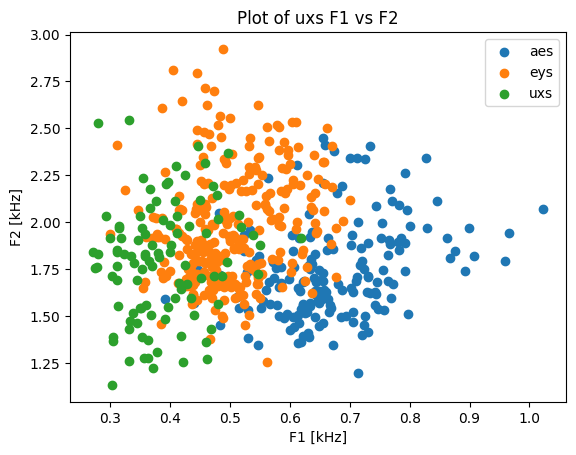

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spst

# %matplotlib notebook

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
# print(test)
# print(test)
print(test[test["Phoneme"] == 'ae'])

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

# Looking at the partial dataframes
# print((aes))

# Plotting here
# plt.scatter(aes["F1"], aes["F2"])
# plt.title("Plot of aes F1 vs F2")
# plt.xlabel("F1")
# plt.ylabel("F2")
# plt.show()
# plt.scatter(eys["F1"], eys["F2"])
# plt.title("Plot of eys F1 vs F2")
# plt.xlabel("F1")
# plt.ylabel("F2")
# plt.show()
# plt.scatter(uxs["F1"], uxs["F2"])
# plt.title("Plot of uxs F1 vs F2")
# plt.xlabel("F1")
# plt.ylabel("F2")
# plt.show()


plt.scatter(aes["F1"], aes["F2"], label = "aes")
plt.scatter(eys["F1"], eys["F2"], label = "eys")
plt.scatter(uxs["F1"], uxs["F2"], label = "uxs")
plt.xlabel("F1 [kHz]")
plt.ylabel("F2 [kHz]")
plt.title("Plot of uxs F1 vs F2")
plt.legend()
plt.show()


I suspect the aes will be the easiest to identify, since they are more separated from the other two in the scatter plot, and the sound itself is shorter, and in the case of "bat" has a defined stop after it, which will probably result in a silence between the /a/ and /t/.
In the scatter plot the other two are much more intertwined, with what appears to be the core of the eys being well within the area the uxs occupy, along with much more thorough overlap.

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [3]:
"""
    Takes a dataset variable containing all the matrices that Gaussian models are to be generated for,
    and calculates some values that will be used further in classification.
"""
def PrepGaussianModels(dataset):
    models = []
    noSamples = 0
    for data in dataset:
        # print(data)
        noSamples += data.shape[0] # Adds number of samples in this vowel dataset to the total number of vowels.
                                   # Must be done first so as to have the total number of samples available for the rest of the code.
    for data in dataset:
        models.append({'mean': [np.mean(data["F1"]), np.mean(data["F2"])], 'covariance': np.cov(data, rowvar = False), 'prior': data.shape[0]/noSamples})
        # models.append({'mean': [np.mean(data),], 'covariance': np.cov(data, rowvar = False), 'prior': data.shape[0]/noSamples})
        # Rowvar set to false since each column should be counted as a distinct variable. Thus looking at the columns as a whole, 
        # not the individual datapoints in the rows.
    return models, noSamples

""" 
    Creates the Gaussian models for classification.
"""
def CreateModels(models):
    dists = []
    priors = []
    for model in models:
        multivar = spst.multivariate_normal(mean = model['mean'], cov = model['covariance'])
        dists.append(multivar)
        priors.append(model["prior"])
    return dists, priors

# def CreateModels(models):
#     dist = []
#     priors = []
#     for model in models:
#         mean = [np.mean(model["mean"])]  # Convert to a 1D array or scalar
#         cov = model["covariance"]
#         multivar = spst.multivariate_normal(mean=mean, cov=cov)
#         dist.append(multivar)
#         priors.append(model["prior"])
#     return dist, priors


""" 
    Classifies data absed on distributions generated in CreateModels.
"""
def ClassifyData(data, dists, priors):
    num_classes = len(dists)
    observations = len(data)
    confusion_matrix = np.zeros((observations, num_classes))
    
    for i in range(len(data)):
        for j in range(len(data[i])):
            pred = []
            for model, dist in enumerate(dists):
                print(dist)
                # print("Test3")
                pred.append(dist.pdf(data[i].iloc[j]) * priors[model]) # Doesn't like this line for some reason.
                # print("Test222")
            prediction = np.argmax(pred)
            confusion_matrix[i][prediction] += 1
    
    return confusion_matrix

""" 
    Function to run all functions in one neat package.
"""
def Classifier(data, models):
    dists, priors = CreateModels(models)
    confusion_matrix = ClassifyData(data, dists, priors)
    return confusion_matrix


# print("aes")
# print(aes[['F1','F2']])
# print("aes over")


# Defining the data that will be used to train the model
trainData = [aes[['F1','F2']], eys[['F1','F2']], uxs[['F1','F2']]]
# print("TrainData")
# print(trainData[1][1])

models, noSamples = PrepGaussianModels(trainData)
print(models)
# print(models)
# for model in models:
#     print(model)
confMatrix = Classifier(trainData, models)
print(confMatrix)









[{'mean': [0.6698604040063185, 1.7423804026807663], 'covariance': array([[0.01060842, 0.00759043],
       [0.00759043, 0.06317165]]), 'prior': 0.31115107913669066}, {'mean': [0.5045519111013244, 1.9784005560217814], 'covariance': array([[0.00602243, 0.00386976],
       [0.00386976, 0.08785495]]), 'prior': 0.5089928057553957}, {'mean': [0.3873842254281044, 1.7894474411010741], 'covariance': array([[0.00493896, 0.00303423],
       [0.00303423, 0.09479051]]), 'prior': 0.17985611510791366}]
[[142.  30.   1.]
 [ 19. 244.  20.]
 [  1.  39.  60.]]


(c) To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [ ]:
import scipy.stats

def plotGaussian(mean, cov, color, ax):
    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

(d) Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

(e) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

(f) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

(g) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [10]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import svm, metrics

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf,data,labels):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(phonemes)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    sns.scatterplot(data[:,0],data[:,1],hue=labels)
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Decision Area of SVM')
    plt.show()

def Plot_Support_Vectors(clf,data):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

ModuleNotFoundError: No module named 'sklearn'

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

More tolerant penalty terms will result in 

In [12]:
# Splitting and recombining data correctly
aes_train = train[train["Phoneme"] == "ae"].loc[:, ["F1", "F2", "F3", "F4"]]


SyntaxError: cannot assign to subscript here. Maybe you meant '==' instead of '='? (2577635804.py, line 2)

(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

Most kernels that are not linear will result in better accuracy for the test data (assuming it is not simply split along a line) but will to varying degrees damage the accuracy of classifications of the training data, since there will be a much higher chance for mis-classification of a datapoint. It's a balance here.